In [1]:
library(DBI)
library(plutoDbR)
library(plutoR)
library(tidyverse)
library(gld)
options("scipen"=999)
options(stringsAsFactors = FALSE)
source("/usr/share/pluto/config.R")
source("/usr/share/pluto/goofy/plot.common.R")
source("/usr/share/pluto/goofy/misc.common.R")

library(pracma)
library(ggthemes)
library(reshape2)
library(quantmod)
library(lubridate)
library(ggrepel)
library(PerformanceAnalytics)
library(ggpubr)

options(repr.plot.width=16, repr.plot.height=8)
options(tibble.width = Inf)

#initialize
equitiesIndiaNse <- EquitiesIndiaNse()
indices <- Indices()

In [2]:
eqSym1 <- 'HDFCBANK'
eqSym2 <- 'KOTAKBANK'
indexSym <- 'NIFTY BANK TR'
startDt <- as.Date("2012-01-01")
endDt <- as.Date("2019-12-31")
lb <- 20 #days

In [3]:
eqDf1 <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
        filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & SYMBOL == eqSym1) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

eqDf2 <- equitiesIndiaNse$EodAdjustedTimeSeries() %>%
        filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & SYMBOL == eqSym2) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

inDf <- indices$NseTimeSeries() %>%
        filter(TIME_STAMP >= startDt & TIME_STAMP <= endDt & NAME == indexSym) %>%
        select(TIME_STAMP, CLOSE) %>%
        collect() %>%
        mutate(TIME_STAMP = as.Date(TIME_STAMP))

In [16]:
eqXts1 <- xts(eqDf1$CLOSE, eqDf1$TIME_STAMP)
eqXts2 <- xts(eqDf2$CLOSE, eqDf2$TIME_STAMP)
inXts <- xts(inDf$CLOSE, inDf$TIME_STAMP)

eqRets1 <- dailyReturn(eqXts1)
eqRets2 <- dailyReturn(eqXts2)
inRets <- dailyReturn(inXts)

allRets <- merge(eqRets1, eqRets2, (eqRets1+eqRets2)/2, inRets)
allRets <- na.omit(allRets)

names(allRets) <- c('E1', 'E2', 'E12', 'I')

In [17]:
linearBeta1 <- rollapply(allRets, lb, function(X){
    lbfit <- lm("E1~I+0", X)
    xts(coefficients(lbfit)[[1]], last(index(X)))
}, by.column=F)

In [18]:
linearBeta2 <- rollapply(allRets, lb, function(X){
    lbfit <- lm("E2~I+0", X)
    xts(coefficients(lbfit)[[1]], last(index(X)))
}, by.column=F)

In [19]:
linearBeta12 <- rollapply(allRets, lb, function(X){
    lbfit <- lm("E12~I+0", X)
    xts(coefficients(lbfit)[[1]], last(index(X)))
}, by.column=F)

In [20]:
linearBeta <- na.omit(merge(linearBeta1,linearBeta2,linearBeta12))
toPlot <- data.frame(linearBeta)
names(toPlot) <- c(eqSym1, eqSym2, 'BOTH')
toPlot$T <- index(linearBeta)

In [32]:
print(summary(linearBeta1))
print(summary(linearBeta2))
print(summary(linearBeta12))

     Index             linearBeta1     
 Min.   :2012-01-02   Min.   :-0.4103  
 1st Qu.:2013-12-27   1st Qu.: 0.5594  
 Median :2015-12-30   Median : 0.6863  
 Mean   :2015-12-28   Mean   : 0.6762  
 3rd Qu.:2017-12-26   3rd Qu.: 0.8056  
 Max.   :2019-12-31   Max.   : 1.5395  
                      NA's   :19       
     Index             linearBeta2     
 Min.   :2012-01-02   Min.   :-0.9001  
 1st Qu.:2013-12-27   1st Qu.: 0.5756  
 Median :2015-12-30   Median : 0.7569  
 Mean   :2015-12-28   Mean   : 0.7325  
 3rd Qu.:2017-12-26   3rd Qu.: 0.9042  
 Max.   :2019-12-31   Max.   : 2.2678  
                      NA's   :19       
     Index             linearBeta12    
 Min.   :2012-01-02   Min.   :-0.6518  
 1st Qu.:2013-12-27   1st Qu.: 0.5980  
 Median :2015-12-30   Median : 0.7223  
 Mean   :2015-12-28   Mean   : 0.7043  
 3rd Qu.:2017-12-26   3rd Qu.: 0.8478  
 Max.   :2019-12-31   Max.   : 1.5131  
                      NA's   :19       


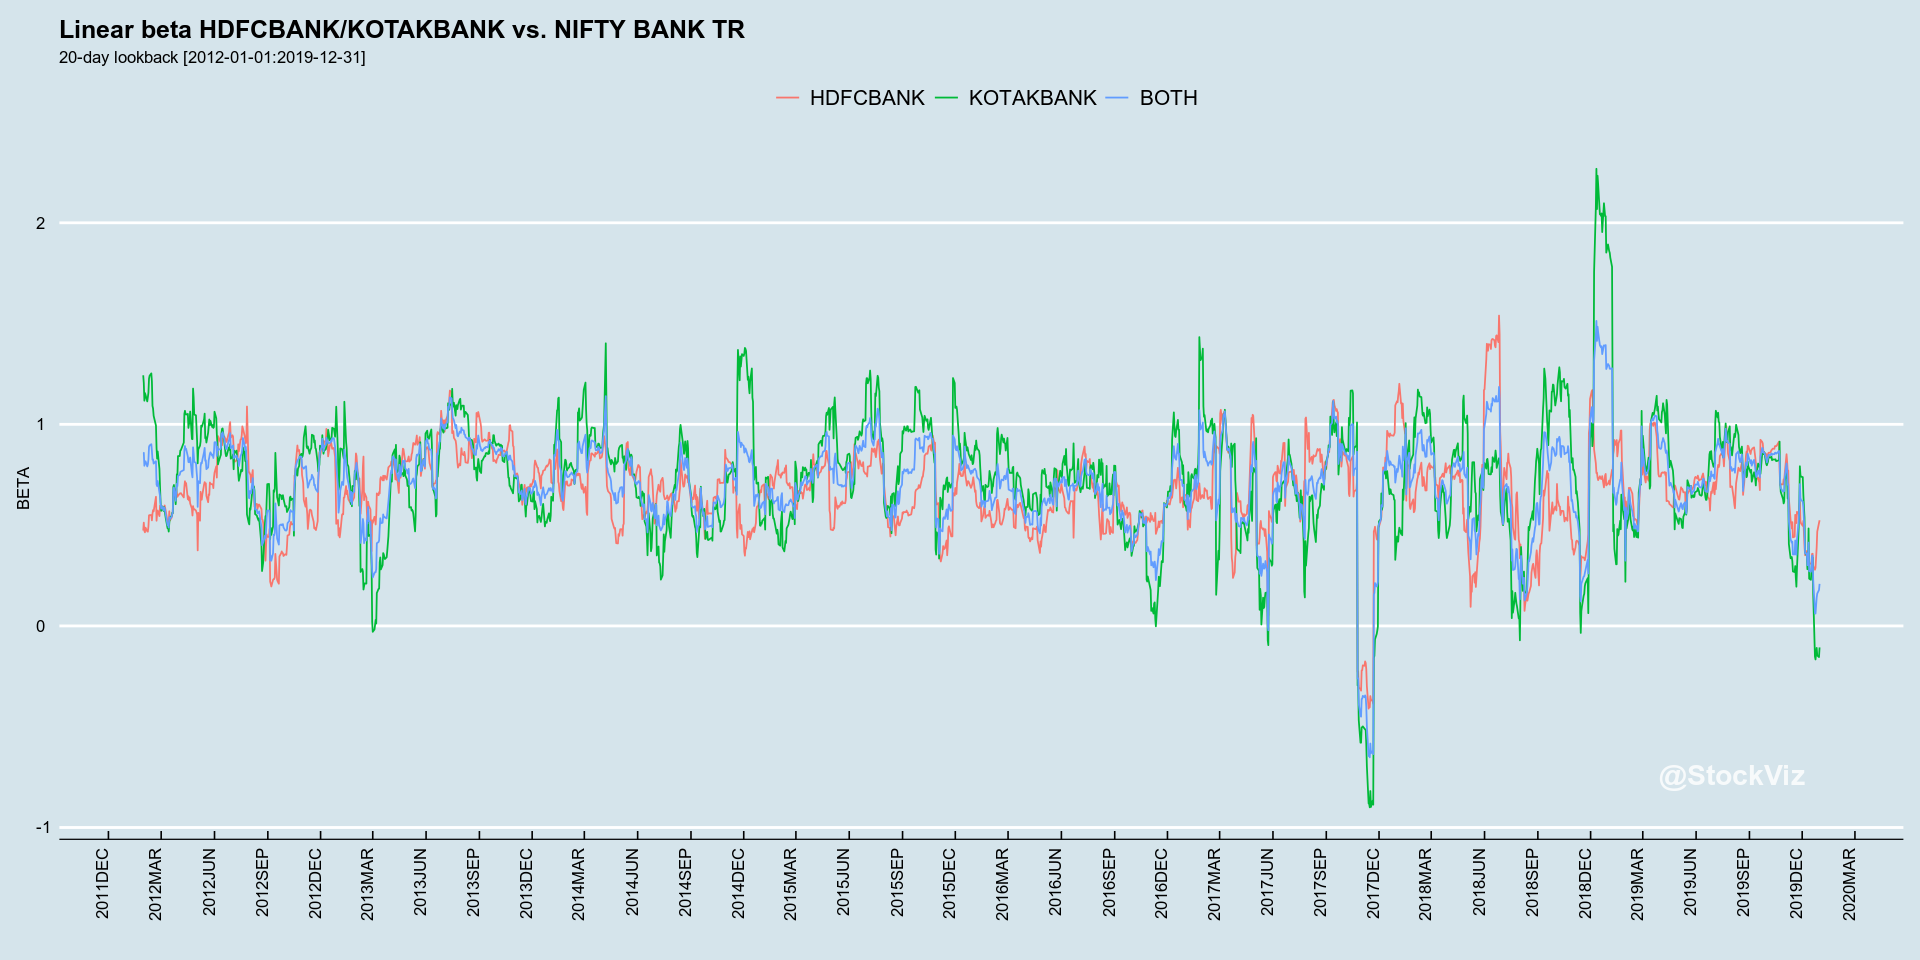

In [22]:
ggplot(melt(toPlot, id='T'), aes(x=T, y=value, color=variable)) +
    theme_economist() +
    theme(axis.text.x=element_text(angle=90, hjust=1)) +
    geom_line() +
    scale_x_date(date_breaks = "3 months", labels = function(X) toupper(strftime(X, "%Y%b"))) +
    labs(x='', y='BETA', color='', fill='', line='', title=sprintf("Linear beta %s/%s vs. %s", eqSym1, eqSym2, indexSym), subtitle=sprintf("%d-day lookback [%s:%s]", lb, startDt, endDt)) +
    annotate("text", x=endDt, y=as.numeric(min(linearBeta)), 
                 label = "@StockViz", hjust=1.1, vjust=-1.1, 
                 col="white", cex=6, fontface = "bold", alpha = 0.8)

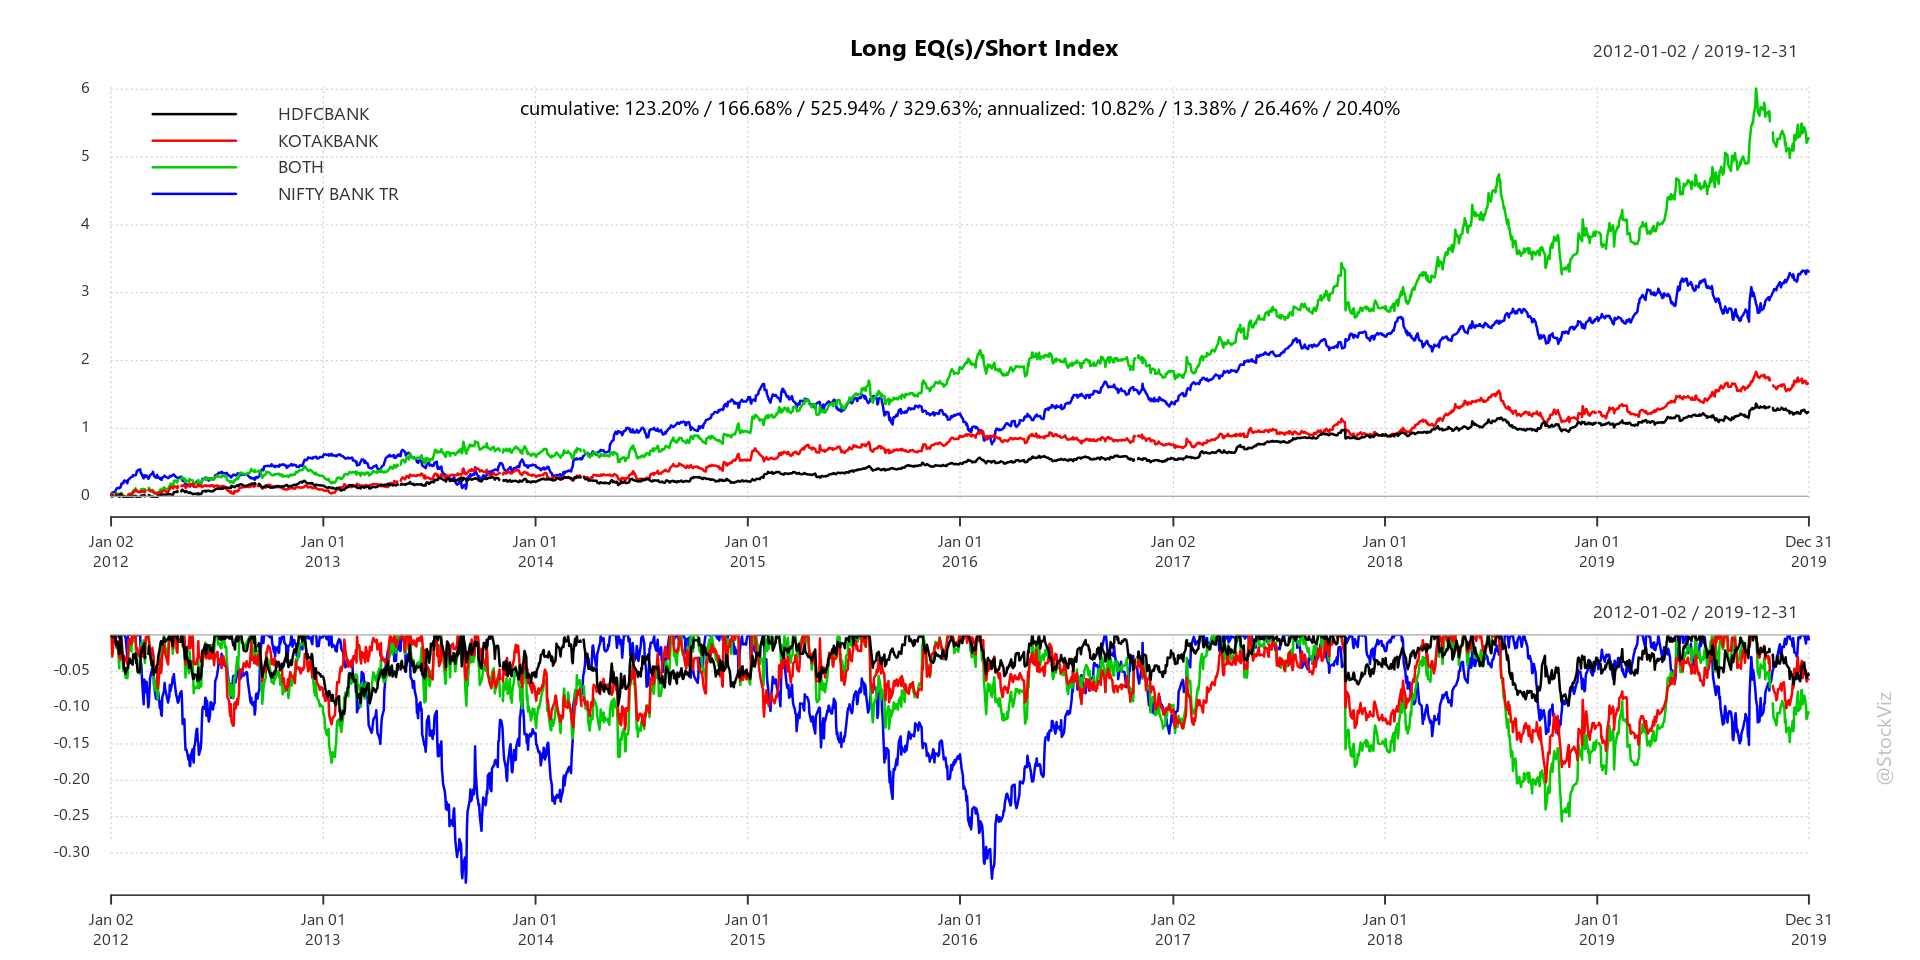

In [36]:
longshort <- merge(eqRets1-0.70*inRets, eqRets2-0.75*inRets, eqRets1+eqRets2-1.4*inRets, inRets)
names(longshort) <- c(eqSym1, eqSym2, 'BOTH', indexSym)
Common.PlotCumReturns(longshort, "Long EQ(s)/Short Index", "")

In [28]:
eqCumRets1 <- rollapply(eqRets1, 10, Return.cumulative)
eqCumRets2 <- rollapply(eqRets2, 10, Return.cumulative)
inCumRets <- rollapply(inRets, 10, Return.cumulative)

allRets <- merge(eqCumRets1, eqCumRets2, inCumRets) #1,2,3
allRets$LAG_EQ1 <- stats::lag(eqRets1, -1)
allRets$LAG_EQ2 <- stats::lag(eqRets2, -1)
allRets$LAG_IN <- stats::lag(inRets, -1)

allRets <- na.omit(allRets)

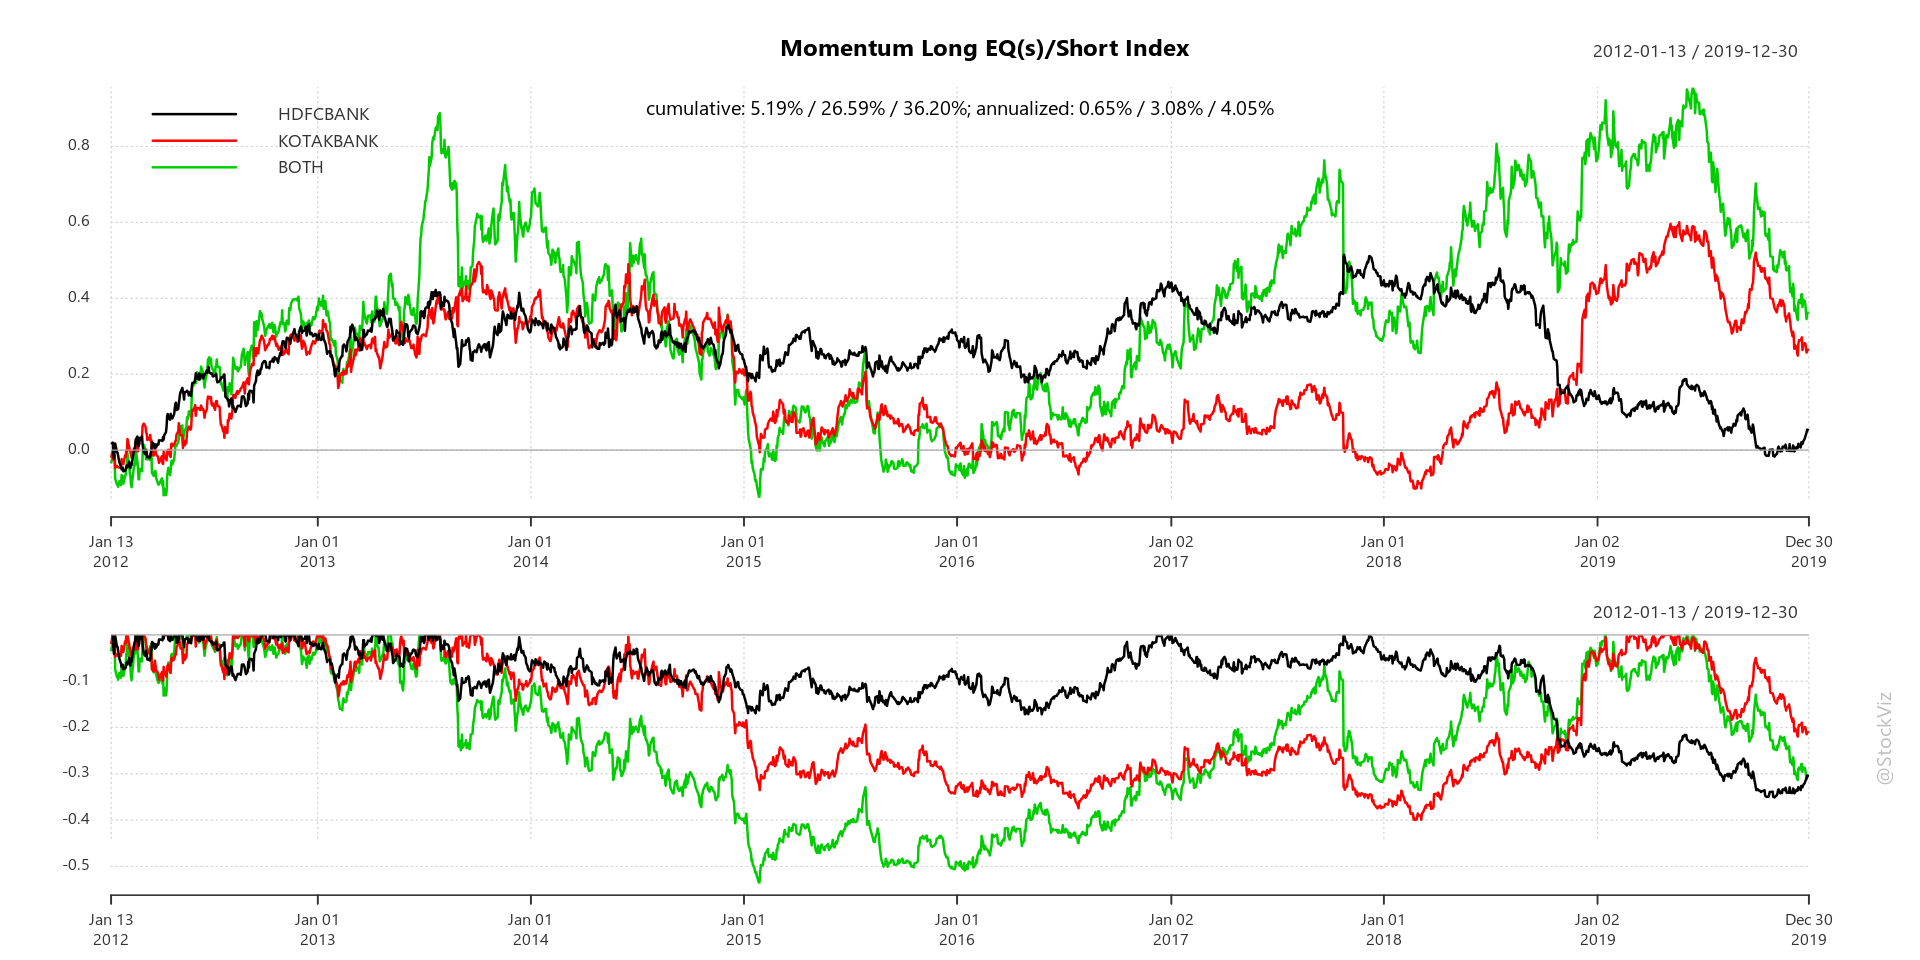

In [31]:
momEq1 <- ifelse(allRets[,1] > allRets[,3], allRets$LAG_EQ1-allRets$LAG_IN, allRets$LAG_IN-allRets$LAG_EQ1)
momEq2 <- ifelse(allRets[,2] > allRets[,3], allRets$LAG_EQ2-allRets$LAG_IN, allRets$LAG_IN-allRets$LAG_EQ2)
momEq12 <- ifelse(allRets[,1]+allRets[,2] > 2*allRets[,3], allRets$LAG_EQ1+allRets$LAG_EQ2-2*allRets$LAG_IN, 2*allRets$LAG_IN-(allRets$LAG_EQ1+allRets$LAG_EQ2))

mom <- merge(momEq1, momEq2, momEq12)
names(mom) <- c(eqSym1, eqSym2, 'BOTH')
Common.PlotCumReturns(mom, "Momentum Long EQ(s)/Short Index", "")

This notebook was created using [pluto](https://pluto.studio). Thank you for playing fair!